In [1]:
import nibabel as nib
import numpy as np
from os.path import join
import math
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp
from statsmodels.stats.multitest import multipletests
from nilearn import plotting
from nilearn.image import resample_to_img
from scipy import ndimage
from scipy.spatial.distance import cdist
from scipy.sparse import csgraph
import cvxpy as cp
from sklearn.model_selection import KFold
from itertools import product
import scipy.io as sio
import h5py
from sklearn.decomposition import PCA

In [2]:
ses = 1
sub = '04'
run = 1

base_path = '/mnt/TeamShare/Data_Masterfile/H20-00572_All-Dressed/PRECISIONSTIM_PD_Data_Results/fMRI_preprocessed_data/Rev_pipeline/derivatives'
anat_img = nib.load(f'/mnt/TeamShare/Data_Masterfile/H20-00572_All-Dressed/PRECISIONSTIM_PD_Data_Results/fMRI_preprocessed_data/Rev_pipeline/derivatives/sub-pd0{sub}/ses-{ses}/anat/sub-pd0{sub}_ses-{ses}_T1w_brain.nii.gz')

data_name = f'sub-pd0{sub}_ses-{ses}_run-{run}_task-mv_bold_corrected_smoothed_reg.nii.gz'
BOLD_path_org = join(base_path, f'sub-pd0{sub}', f'ses-{ses}', 'func', data_name)
bold_img = nib.load(BOLD_path_org)
bold_data = bold_img.get_fdata()
bold_data = bold_data.astype(np.float16)

mask_path = f'/mnt/TeamShare/Data_Masterfile/H20-00572_All-Dressed/PRECISIONSTIM_PD_Data_Results/fMRI_preprocessed_data/Rev_pipeline/derivatives/sub-pd0{sub}/ses-{ses}/anat/sub-pd0{sub}_ses-{ses}_T1w_brain_mask.nii.gz'
back_mask = nib.load(mask_path)
back_mask = back_mask.get_fdata()
back_mask = back_mask.astype(np.float16)

mask_path = f'/mnt/TeamShare/Data_Masterfile/H20-00572_All-Dressed/PRECISIONSTIM_PD_Data_Results/fMRI_preprocessed_data/Rev_pipeline/derivatives/sub-pd0{sub}/ses-{ses}/anat/sub-pd0{sub}_ses-{ses}_T1w_brain_pve_0.nii.gz'
csf_mask = nib.load(mask_path)
csf_mask = csf_mask.get_fdata()
csf_mask = csf_mask.astype(np.float16)

mask_path = f'/mnt/TeamShare/Data_Masterfile/H20-00572_All-Dressed/PRECISIONSTIM_PD_Data_Results/fMRI_preprocessed_data/Rev_pipeline/derivatives/sub-pd0{sub}/ses-{ses}/anat/sub-pd0{sub}_ses-{ses}_T1w_brain_pve_1.nii.gz'
white_mask = nib.load(mask_path)
white_mask = white_mask.get_fdata()
white_mask = white_mask.astype(np.float16)

# print(anat_img.shape)
# print(bold_data.shape)
# print(back_mask.shape)
# print(csf_mask.shape)

In [ ]:
back_mask_data = back_mask > 0
csf_mask_data = csf_mask > 0
white_mask_data = white_mask > 0.5
mask = np.logical_and(back_mask_data, ~csf_mask_data)
mask &= ~white_mask_data
nonzero_mask = np.where(mask)
masked_bold = bold_data[nonzero_mask]

print(f"number of selected voxels after masking: {masked_bold.shape[0]/math.prod(bold_data.shape[:3])*100:.2f}%")
print('bold_data masked shape:', masked_bold.shape)

In [4]:
# mask_img = nib.Nifti1Image(mask, bold_img.affine, bold_img.header)
# mask_img = resample_to_img(mask_img, anat_img, interpolation="nearest")

# # interactive overlay
# view = plotting.view_img(
#     mask_img,
#     bg_img=anat_img,
#     cmap="autumn",
#     opacity=0.7,
#     threshold=0,
#     colorbar=False
# )
# view 

In [ ]:
glm_dict = np.load(f'TYPED_FITHRF_GLMDENOISE_RR.npy', allow_pickle=True).item()
beta_glm = glm_dict['betasmd']
beta_run1, beta_run2 = beta_glm[:,0,0,:90], beta_glm[:,0,0,90:]
R2_run1, R2_run2 = glm_dict['R2run'][:,:,:,0], glm_dict['R2run'][:,:,:,1]

mask = np.logical_and(back_mask_data, ~csf_mask_data)
nonzero_mask = np.where(mask)
white_mask_flat = white_mask_data[nonzero_mask]
beta = beta_run1[~white_mask_flat]
print("Beta Range:[", np.nanmin(beta), np.nanmax(beta), "], Mean: ", np.nanmean(beta))
# plt.figure()
# plt.hist(beta.flatten(), bins=100)
# plt.title('Histogram of Beta Values (Run 1)')
# plt.xlabel('Beta Value')
R2 = R2_run1[~white_mask_flat]

lower_thr, upper_thr = np.nanpercentile(beta, [1, 99])
print(f'low_thr: {lower_thr:.2f}, high_thr: {upper_thr:.2f}') #low_thr: -4.64, high_thr: 4.60
beta_extreme_mask = np.logical_or(beta < lower_thr, beta > upper_thr)
voxels_with_extreme_beta = np.any(beta_extreme_mask, axis=1)

print(f"percentage of voxels with extreme beta values: {np.sum(voxels_with_extreme_beta)/beta.shape[0]*100:.2f}%")

mask = np.logical_and(back_mask_data, ~csf_mask_data)
mask &= ~white_mask_data
nonzero_mask = np.where(mask)

In [6]:
# tmp = beta[voxels_with_extreme_beta]
# print("Extreme Beta Range:[", np.nanmin(tmp), np.nanmax(tmp), "], Mean: ", np.nanmean(tmp))
# plt.figure()
# plt.hist(tmp.flatten())
# plt.title('Histogram of Extreme Beta Values (Run 1)')
# plt.xlabel('Beta Value')

In [7]:
# extreme_volume = np.zeros(bold_img.shape[:3], dtype=np.float32)
# extreme_volume[nonzero_mask] = voxels_with_extreme_beta.astype(np.float32)
# extreme_img = nib.Nifti1Image(extreme_volume, bold_img.affine, bold_img.header)
# extreme_img = resample_to_img(extreme_img, anat_img, interpolation='nearest')
# view = plotting.view_img(
#     extreme_img,
#     bg_img=anat_img,
#     cmap='autumn',
#     symmetric_cmap=False,
#     threshold=0.5,
#     vmax=1,
#     opacity=0.9,
#     title='Voxels with Extreme Betas'
# )
# view
# view.save_as_html(file_name=f'extreme_beta_voxels_sub{sub}_ses{ses}_run{run}.html')


In [ ]:
# after removing voxels with extreme beta values
clean_beta = beta[~voxels_with_extreme_beta]
clean_R2 = R2[~voxels_with_extreme_beta]
print('clean_beta shape:', clean_beta.shape)

# plt.hist(clean_beta.flatten(), bins=100)
# plt.title('Histogram of Cleaned Beta Values (Run 1)')
# plt.xlabel('Beta Value')
# plt.show()

In [ ]:
# one sample t-test against 0
tvals, pvals = ttest_1samp(clean_beta, popmean=0, axis=1, nan_policy='omit')

# FDR correction
tested = np.isfinite(pvals)
alpha=0.05
rej, q, _, _ = multipletests(pvals[tested], alpha=alpha, method='fdr_bh')

n_voxel = clean_beta.shape[0]
qvals  = np.full(n_voxel, np.nan)
reject = np.zeros(n_voxel, dtype=bool)
reject[tested] = rej
qvals[tested]  = q

# reject non-active voxels
clean_active_beta = clean_beta[reject]
clean_active_R2 = clean_R2[reject]
print(f"{clean_active_beta.shape[0]/clean_beta.shape[0]*100:.2f}% of voxels are active at FDR q<{alpha}")

In [10]:
# # Map mean beta for active voxels back into anatomical space
# clean_mask = ~np.asarray(voxels_with_extreme_beta, dtype=bool)
# clean_indices = np.flatnonzero(clean_mask)
# active_mask = np.asarray(reject, dtype=bool)
# active_indices = clean_indices[active_mask]


# active_voxel_coords = tuple(idx[active_indices] for idx in nonzero_mask)

# mean_active_beta = np.nanmean(clean_active_beta, axis=1).astype(np.float32)
# mean_beta_volume = np.full(bold_img.shape[:3], np.nan, dtype=np.float32)
# mean_beta_volume[active_voxel_coords] = mean_active_beta

# mean_beta_img = nib.Nifti1Image(mean_beta_volume, bold_img.affine, bold_img.header)
# mean_beta_img = resample_to_img(mean_beta_img, anat_img, interpolation='linear')

# finite_vals = np.isfinite(mean_active_beta)
# if np.any(finite_vals):
#     vmax = np.nanpercentile(mean_active_beta[finite_vals], 99)
#     vmin = np.nanpercentile(mean_active_beta[finite_vals], 1)
# else:
#     vmax = vmin = 0.0

# active_beta_view = plotting.view_img(
#     mean_beta_img,
#     bg_img=anat_img,
#     cmap='seismic',
#     symmetric_cmap=False,
#     threshold=1e-6,
#     vmax=vmax,
#     vmin=vmin,
#     colorbar=True,
#     title='Mean beta for active voxels'
# )
# active_beta_view
# # active_beta_view.save_as_html(file_name=f'active_beta_map_sub{sub}_ses{ses}_run{run}.html')

In [11]:
# # Visualise which voxels survived the active-voxel selection
# active_mask_volume = np.zeros(bold_img.shape[:3], dtype=np.uint8)
# active_mask_volume[active_voxel_coords] = 1

# active_mask_img = nib.Nifti1Image(active_mask_volume.astype(np.float32), bold_img.affine, bold_img.header)
# active_mask_img = resample_to_img(active_mask_img, anat_img, interpolation='nearest')

# active_mask_view = plotting.view_img(
#     active_mask_img,
#     bg_img=anat_img,
#     cmap='autumn',
#     symmetric_cmap=False,
#     threshold=0.5,
#     vmax=1,
#     opacity=0.9,
#     title='Active voxels mask'
# )
# active_mask_view
# active_mask_view.save_as_html(file_name=f'active_voxels_sub{sub}_ses{ses}_run{run}.html')

In [ ]:
# transfer back beta value on the volume
clean_mask = ~np.asarray(voxels_with_extreme_beta, dtype=bool)
clean_indices = np.nonzero(clean_mask)[0]
active_indices = clean_indices[np.asarray(reject, dtype=bool)]

spatial_shape = bold_img.shape[:3]
n_trials = clean_active_beta.shape[1]
beta_volume = np.full(spatial_shape + (n_trials,), np.nan, dtype=np.float32)

coords = tuple(axis[active_indices] for axis in nonzero_mask)
beta_volume[coords[0], coords[1], coords[2], :] = clean_active_beta.astype(np.float32)

In [ ]:
# def hampel_filter_image(image, window_size, threshold_factor):
#     if window_size % 2 == 0:
#         raise ValueError("window_size must be odd")
        
#     filtered = image.astype(float).copy()
#     footprint = np.ones((window_size,)*3, dtype=bool)

#     print(image.shape[3])
#     for t in range(image.shape[3]):
#         print(t)
#         vol = image[..., t]
#         med = ndimage.generic_filter(vol, np.nanmedian, footprint=footprint, mode='constant', cval=np.nan)
#         mad = ndimage.generic_filter(np.abs(vol - med), np.nanmedian, footprint=footprint, mode='constant', cval=np.nan)

#         scaled_mad = 1.4826 * mad  # Gaussian-consistent scaling
#         valid = ~np.isnan(vol)
#         outliers = valid & (np.abs(vol - med) > threshold_factor * scaled_mad)
#         filtered[..., t][outliers] = np.nan
#     return filtered

def hampel_filter_image(image, window_size, threshold_factor):
    if window_size % 2 == 0:
        raise ValueError("window_size must be odd")

    filtered = image.astype(float).copy()
    footprint = np.ones((window_size,) * 3, dtype=bool)

    for t in range(image.shape[3]):
        print(t)
        vol = image[..., t]
        med = ndimage.generic_filter(vol, np.nanmedian, footprint=footprint, mode='constant', cval=np.nan)
        mad = ndimage.generic_filter(np.abs(vol - med), np.nanmedian, footprint=footprint, mode='constant', cval=np.nan)
        counts = ndimage.generic_filter(np.isfinite(vol).astype(np.float32), np.sum, footprint=footprint, mode='constant', cval=0)

        scaled_mad = 1.4826 * mad  # Gaussian-consistent scaling
        valid = np.isfinite(vol)
        insufficient = counts < 3

        filtered[..., t][insufficient] = np.nan

        enough_data = (counts >= 3) & valid
        outliers = enough_data & (np.abs(vol - med) > threshold_factor * scaled_mad)
        filtered[..., t][outliers] = med[outliers]
    return filtered
beta_volume_filter = hampel_filter_image(beta_volume, window_size=5, threshold_factor=3)
np.save(f'cleaned_beta_volume_sub{sub}_ses{ses}_run{run}.npy', beta_volume_filter)

In [ ]:
beta_volume_filter = np.load("beta_volume_filter.npy")
bold_data = bold_img.get_fdata()
beta_volume_filter.shape

In [ ]:
beta_volume_filter = beta_volume_filter.astype(np.float16)
spatial_shape = beta_volume_filter.shape[:-1]
voxels_with_any_nan = np.zeros(spatial_shape, dtype=bool)
voxels_with_all_nan = np.ones(spatial_shape, dtype=bool)

# Sweep the time dimension once
for t in range(beta_volume_filter.shape[-1]):
    frame_nan = np.isnan(beta_volume_filter[..., t])
    voxels_with_any_nan |= frame_nan
    voxels_with_all_nan &= frame_nan

print(np.sum(voxels_with_any_nan), np.sum(voxels_with_all_nan), flush=True)

n_trial = beta_volume_filter.shape[-1]
beta_volume_filter_2d = beta_volume_filter.reshape(-1, n_trial)
print(beta_volume_filter_2d.shape, flush=True)
mask_2d = voxels_with_all_nan.reshape(-1)
beta_valume_clean_2d = beta_volume_filter_2d[~mask_2d]
print(beta_valume_clean_2d.shape, flush=True)
np.save(f'beta_valume_clean_2d.npy', beta_valume_clean_2d)

In [9]:
del anat_img, back_mask, csf_mask, white_mask, mask, nonzero_mask, masked_bold
del R2_run1, R2_run2, beta_run1, beta_run2, R2, beta, clean_beta, clean_R2, voxels_with_all_nan, voxels_with_any_nan
del beta_volume_filter_2d, beta_valume_clean_2d

In [ ]:
# # Compare clean_active_beta with the filtered volume to quantify NaNs introduced by filtering
# filtered_active_beta = beta_volume_filter[coords[0], coords[1], coords[2], :]
# filtered_active_beta = filtered_active_beta.reshape(clean_active_beta.shape)

# nan_before = np.isnan(clean_active_beta)
# nan_after = np.isnan(filtered_active_beta)

# voxels_before_nan = np.sum(nan_before.any(axis=1))
# voxels_after_nan = np.sum(nan_after.any(axis=1))
# new_nan_voxels = np.sum(~nan_before.any(axis=1) & nan_after.any(axis=1))

# voxel_count = clean_active_beta.shape[0]
# entry_count = clean_active_beta.size

# # print(f"Active voxels evaluated: {voxel_count}")
# # print(f"Voxels with NaNs before filtering: {voxels_before_nan}")
# # print(f"Voxels with NaNs after filtering: {voxels_after_nan}")
# # print(f"New voxels turned NaN by filtering: {new_nan_voxels}")
# # print(f"Fraction of voxels with any NaN after filtering: {voxels_after_nan/voxel_count:.2%}")
# # print(f"NaN entries before filtering: {nan_before.sum()} / {entry_count}")
# print(f"{nan_after.sum() / entry_count *100: .2f}% of voxels are filtered")
# # print(f"New NaN entries introduced by filtering: {(~nan_before & nan_after).sum()} / {entry_count}")

In [20]:
beta_valume_clean_2d = np.load(f'beta_valume_clean_2d.npy')
beta_valume_clean_2d.shape

(296838, 90)

In [ ]:
# bold_data_reshape = bold_data.reshape(-1, bold_data.shape[-1])
# bold_data_reshape = bold_data_reshape.astype(np.float16)
# bold_data_selected = bold_data_reshape[~mask_2d]         # keep voxels of interest
# bold_data_selected = bold_data_selected.astype(np.float16)
# trial_len = 9
# num_trials = bold_data.shape[-1]
# trial_idx = np.arange(num_trials)
# bold_data_selected_reshape = np.zeros((bold_data_selected.shape[0], num_trials, trial_len), dtype=np.float16)

In [ ]:
# start = 0

# for i in range(num_trials):
#     end = start + trial_len
#     if end > bold_data_selected.shape[1]:
#         raise ValueError("BOLD data does not contain enough timepoints for all trials")
#     bold_data_selected_reshape[:, i, :] = bold_data_selected[:, start:end]
#     start += trial_len
#     if start == 270 or start == 560:   # your skips
#         start += 20
# X = bold_data_selected_reshape[:, trial_idx, :]          # [Nvox, Ntrials, T]

In [ ]:
# import numpy as np
# X = np.load('X.npy')
# X.shape

(296838, 90, 9)

In [ ]:
# from sklearn.decomposition import PCA
# pca = PCA()
# X_reshap = X.reshape(X.shape[0], -1).astype(np.float32)
# X_pca = pca.fit_transform(X_reshap.T) #(810, 800)

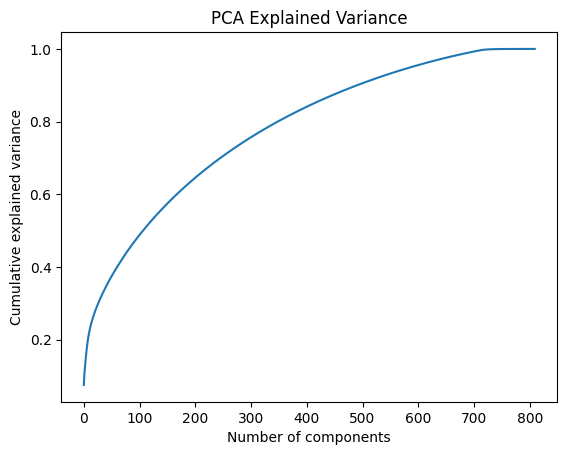

np.int64(588)

In [26]:
import matplotlib.pyplot as plt
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("PCA Explained Variance")
plt.show()


tmp = np.cumsum(pca.explained_variance_ratio_)
np.where(tmp>0.95)[0][0]

In [ ]:
# del beta_valume_clean_2d
# beta_valume_clean_2d = np.load(f'beta_valume_clean_2d.npy')
# print(beta_valume_clean_2d.shape)
# print(f"beta reduced range: ", beta_valume_clean_2d.min(), beta_valume_clean_2d.max())

# components = pca.components_[:600]
# mean = pca.mean_
# print(mean.shape)
# print(components.shape)


# # beta_reduced = pca.transform(beta_valume_clean_2d.T)
# beta_reduced = (beta_valume_clean_2d.T - mean) @ components.T
# beta_reduced = beta_reduced.T
# print(beta_reduced.shape)
# print(f"beta reduced range: ", beta_reduced.min(), beta_reduced.max())

In [ ]:
# # Visualize the mean filtered beta volume on the anatomical brain
# if beta_volume_filter.ndim == 4 and beta_volume_filter.shape[-1] > 1:
#     with np.errstate(invalid='ignore'):
#         beta_filter_mean = np.nanmean(beta_volume_filter, axis=-1)
# else:
#     beta_filter_mean = np.asanyarray(beta_volume_filter).squeeze()

# beta_filter_mean = beta_filter_mean.astype(np.float32)

# beta_filter_img = nib.Nifti1Image(beta_filter_mean, bold_img.affine, bold_img.header)
# beta_filter_img = resample_to_img(beta_filter_img, anat_img, interpolation='linear')

# finite_vals = np.isfinite(beta_filter_mean)
# if np.any(finite_vals):
#     vmax = np.nanpercentile(beta_filter_mean[finite_vals], 99)
#     vmin = np.nanpercentile(beta_filter_mean[finite_vals], 1)
# else:
#     vmax = vmin = 0.0

# beta_filter_view = plotting.view_img(
#     beta_filter_img,
#     bg_img=anat_img,
#     cmap='seismic',
#     symmetric_cmap=False,
#     threshold=1e-6,
#     vmax=vmax,
#     vmin=vmin,
#     colorbar=True,
#     title='Mean filtered beta volume'
# )
# beta_filter_view
# beta_filter_view.save_as_html(file_name=f'filtered_beta_map_sub{sub}_ses{ses}_run{run}.html')

The right one before PCA (L_smooth doesn't look correct. You don't use the anat file)

In [ ]:
# def calculate_matrices(beta_valume_clean_2d, bold_data, anat_img, mask_2d, trial_indices=None, trial_len=9):
#     num_trials = beta_valume_clean_2d.shape[-1]
#     trial_idx = np.arange(num_trials) if trial_indices is None else np.unique(np.asarray(trial_indices, int).ravel())

#     # ----- L_task (same idea as yours) -----
#     beta_selected = beta_valume_clean_2d[:, trial_idx]
#     counts = np.count_nonzero(np.isfinite(beta_selected), axis=-1)
#     sums = np.nansum(beta_selected, axis=-1, dtype=np.float64)
#     mean_beta = np.zeros(beta_selected.shape[0], dtype=np.float32)
#     m = counts > 0
#     mean_beta[m] = (sums[m] / counts[m]).astype(np.float32)
#     L_task = np.zeros_like(mean_beta, dtype=np.float32)
#     v = np.abs(mean_beta) > 0
#     L_task[v] = (1.0 / np.abs(mean_beta[v])).astype(np.float32)

#     # ----- reshape BOLD into trials -----
#     bold_data_reshape = bold_data.reshape(-1, bold_data.shape[-1])
#     bold_data_selected = bold_data_reshape[~mask_2d]         # keep voxels of interest
#     bold_data_selected_reshape = np.zeros((bold_data_selected.shape[0], num_trials, trial_len), dtype=np.float32)
#     start = 0
#     for i in range(num_trials):
#         end = start + trial_len
#         if end > bold_data_selected.shape[1]:
#             raise ValueError("BOLD data does not contain enough timepoints for all trials")
#         bold_data_selected_reshape[:, i, :] = bold_data_selected[:, start:end]
#         start += trial_len
#         if start == 270 or start == 560:   # your skips
#             start += 20
#     X = bold_data_selected_reshape[:, trial_idx, :]          # [Nvox, Ntrials, T]

#     # ----- L_var: variance of trial differences, as sparse diagonal -----
#     m = np.zeros((X.shape[0], X.shape[0]), dtype=np.float32)
#     for i in range(num_trials-1):
#         x1 = X[:, i, :]
#         x2 = X[:, i+1, :]
#         m += (x1-x2) @ (x1-x2).T
#     L_var /= (num_trials - 1)

#     # diff_mat = np.diff(X, axis=1)
#     # diff_mat_flat = diff_mat.reshape(diff_mat.shape[0], -1)
#     # L_var = np.cov(diff_mat_flat, bias=False, dtype=np.float32)
#     # L_var = (L_var + L_var.T) / 2 + 1e-6 * np.eye(L_var.shape[0], dtype=np.float32)

#     # ----- L_smooth: sparse 6-neighbor Laplacian on the voxel grid -----
#     mask3d = (~mask_2d).reshape(bold_data.shape[:3])
#     idx = -np.ones(mask3d.shape, dtype=np.int64)
#     idx[mask3d] = np.arange(mask3d.sum())
#     rows, cols = [], []
#     for ax in range(3):
#         s1 = [slice(None)]*3; s2 = [slice(None)]*3
#         s1[ax] = slice(1, None); s2[ax] = slice(0, -1)
#         a, b = idx[tuple(s1)], idx[tuple(s2)]
#         m = (a != -1) & (b != -1)
#         i, j = a[m].ravel(), b[m].ravel()
#         rows.append(np.concatenate([i, j])); cols.append(np.concatenate([j, i]))
#     if rows:
#         rows, cols = np.concatenate(rows), np.concatenate(cols)
#         A = sp.coo_matrix((np.ones(rows.size, np.float32), (rows, cols)), shape=(idx.max()+1, idx.max()+1)).tocsr()
#         d = np.asarray(A.sum(axis=1)).ravel()
#         L_smooth = (sp.diags(d, 0) - A).astype(np.float32).tocsc()
#     else:
#         L_smooth = sp.csc_matrix((idx.max()+1, idx.max()+1), dtype=np.float32)

#     selected_BOLD_flat = X.reshape(X.shape[0], -1).astype(np.float32)
#     return L_task.astype(np.float32), L_var, L_smooth, selected_BOLD_flat

Test

In [ ]:
# # ---- apply PCA ----
# X = np.load('X.npy')
# pca = PCA()
# X_reshap = X.reshape(X.shape[0], -1).astype(np.float32)
# X_pca = pca.fit_transform(X_reshap.T) #(810, 800)

# beta_valume_clean_2d = np.load(f'beta_valume_clean_2d.npy')
# components = pca.components_[:600]
# mean = pca.mean_
# beta_reduced = (beta_valume_clean_2d.T - mean) @ components.T
# beta_reduced = beta_reduced.T

# num_trials = beta_valume_clean_2d.shape[-1]
# trial_idx = np.arange(num_trials)
# trial_len = 9

# # ----- L_task (same idea as yours) -----
# beta_selected = beta_reduced[:, trial_idx]
# counts = np.count_nonzero(np.isfinite(beta_selected), axis=-1)
# sums = np.nansum(beta_selected, axis=-1, dtype=np.float64)
# mean_beta = np.zeros(beta_selected.shape[0], dtype=np.float32)
# m = counts > 0
# mean_beta[m] = (sums[m] / counts[m]).astype(np.float32)
# L_task = np.zeros_like(mean_beta, dtype=np.float32)
# v = np.abs(mean_beta) > 0
# L_task[v] = (1.0 / np.abs(mean_beta[v])).astype(np.float32)

# # ----- L_var: variance of trial differences, as sparse diagonal -----
# X_pca = X_pca[:, :600].T
# X = X_pca.reshape(X_pca.shape[0], num_trials, trial_len)
# L_var = np.zeros((X.shape[0], X.shape[0]), dtype=np.float32)
# for i in range(num_trials-1):
#     x1 = X[:, i, :]
#     x2 = X[:, i+1, :]
#     L_var += (x1-x2) @ (x1-x2).T
# L_var /= (num_trials - 1)

In [ ]:
def calculate_matrices(beta_valume_clean_2d, bold_data, mask_2d, trial_indices=None, trial_len=9, num_components=600):
    num_trials = beta_valume_clean_2d.shape[-1]
    trial_idx = np.arange(num_trials) if trial_indices is None else np.unique(np.asarray(trial_indices, int).ravel())
    pca = PCA()
    X_reshap = X.reshape(X.shape[0], -1).astype(np.float32)
    X_pca = pca.fit_transform(X_reshap.T) #(810, 800)

    components = pca.components_[:num_components]
    mean = pca.mean_
    beta_reduced = (beta_valume_clean_2d.T - mean) @ components.T
    beta_reduced = beta_reduced.T


    # ----- L_task (same idea as yours) -----
    beta_selected = beta_reduced[:, trial_idx]
    counts = np.count_nonzero(np.isfinite(beta_selected), axis=-1)
    sums = np.nansum(beta_selected, axis=-1, dtype=np.float64)
    mean_beta = np.zeros(beta_selected.shape[0], dtype=np.float32)
    m = counts > 0
    mean_beta[m] = (sums[m] / counts[m]).astype(np.float32)
    L_task = np.zeros_like(mean_beta, dtype=np.float32)
    v = np.abs(mean_beta) > 0
    L_task[v] = (1.0 / np.abs(mean_beta[v])).astype(np.float32)

    # ----- reshape BOLD into trials -----
    bold_data_reshape = bold_data.reshape(-1, bold_data.shape[-1])
    bold_data_selected = bold_data_reshape[~mask_2d]         # keep voxels of interest
    bold_data_selected_reshape = np.zeros((bold_data_selected.shape[0], num_trials, trial_len), dtype=np.float32)
    start = 0
    for i in range(num_trials):
        end = start + trial_len
        if end > bold_data_selected.shape[1]:
            raise ValueError("BOLD data does not contain enough timepoints for all trials")
        bold_data_selected_reshape[:, i, :] = bold_data_selected[:, start:end]
        start += trial_len
        if start == 270 or start == 560:   # your skips
            start += 20
    X = bold_data_selected_reshape[:, trial_idx, :]          # [Nvox, Ntrials, T]

    # ----- L_var: variance of trial differences, as sparse diagonal -----
    X_pca = X_pca[:, :600].T
    X = X_pca.reshape(X_pca.shape[0], num_trials, trial_len)
    L_var = np.zeros((X.shape[0], X.shape[0]), dtype=np.float32)
    for i in range(num_trials-1):
        x1 = X[:, i, :]
        x2 = X[:, i+1, :]
        L_var += (x1-x2) @ (x1-x2).T
    L_var /= (num_trials - 1)

    selected_BOLD_flat = X.reshape(X.shape[0], -1).astype(np.float32)
    return L_task.astype(np.float32), L_var, selected_BOLD_flat

In [23]:
def objective_func(w, L_task, L_var, L_smooth, alpha_var, alpha_smooth):
    quad = (w.T @ np.diag(L_task) @ w + alpha_var * (w.T @ L_var @ w) + alpha_smooth * (w.T @ L_smooth @ w))
    return quad

In [24]:
def optimize_voxel_weights(L_task, L_var, L_smooth, alpha_var, alpha_smooth):
    L_total = np.diag(L_task) + alpha_var * L_var + alpha_smooth * L_smooth
    n = L_total.shape[0]
    L_total = np.nan_to_num(L_total)
    L_total = 0.5*(L_total + L_total.T) + 1e-8*np.eye(n)
    w = cp.Variable(n, nonneg=True)
    constraints = [cp.sum(w) == 1]

    # objective = cp.Minimize(cp.quad_form(w, L_total) + alpha_sparse * cp.norm1(w))
    objective = cp.Minimize(cp.quad_form(w, L_total))
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.OSQP, verbose=True)
    return w.value


In [25]:
def calculate_weight(param_grid, beta_valume_clean_2d, bold_data, anat_img, mask_2d, trial_len):
    kf = KFold(n_splits=2, shuffle=True, random_state=0)
    best_score = np.inf
    best_params = None
    num_trials = beta_valume_clean_2d.shape[-1]

    for a_var, a_smooth in product(*param_grid.values()):
        fold_scores = []
        print(f"a_var: {a_var}, a_smooth: {a_smooth}")
        count = 1

        for train_idx, val_idx in kf.split(np.arange(num_trials)):
            print(f"k-fold num: {count}")
            L_task_train, L_var_train, L_smooth_train, _ = calculate_matrices(beta_valume_clean_2d, bold_data, anat_img, mask_2d, train_idx, trial_len)
            w = optimize_voxel_weights(L_task_train, L_var_train, L_smooth_train, alpha_var=a_var, alpha_smooth=a_smooth)

            L_task_val, L_var_val, L_smooth_val, _ = calculate_matrices(beta_valume_clean_2d, bold_data, anat_img, mask_2d, val_idx, trial_len)

            fold_scores.append(objective_func(w, L_task_val, L_var_val, L_smooth_val, a_var, a_smooth))
            print(f"fold_scores: {fold_scores}")
            count += 1

        mean_score = np.mean(fold_scores)
        print(mean_score)
        if mean_score < best_score:
            best_score = mean_score
            best_params = (a_var, a_smooth)

    print("Best parameters:", best_params, "with CV loss:", best_score)
    return best_params, best_score

In [ ]:
param_grid = {
    "alpha_var":   [1.0],
    "alpha_smooth":[1.0]}

import scipy.sparse as sp
trial_len = 9
best_params, best_score = calculate_weight(param_grid, beta_valume_clean_2d, bold_data, anat_img, mask_2d, trial_len)

# L_task, L_var, L_smooth, selected_BOLD_data = calculate_matrices(beta_valume_clean_2d, bold_data, anat_img, mask_2d, None, trial_len)
# weights = optimize_voxel_weights(L_task, L_var, L_smooth, alpha_var=best_params[0], alpha_smooth=best_params[1])
# weight_img, masked_weights, y = select_opt_weight(selected_BOLD_data, weights, active_low_var_voxels.astype(bool), affine)
# print(y.shape)

In [ ]:
L_task, L_var, L_smooth, selected_BOLD_data = calculate_matrices(beta_valume_clean_2d, bold_data, anat_img, mask_2d, None, trial_len)
weights = optimize_voxel_weights(L_task, L_var, L_smooth, alpha_var=best_params[0], alpha_smooth=best_params[1])
y = selected_BOLD_data.T @ weights

np.save('weights.npy', weights)
np.save('y.npy', y)
print("Finished!", flush=True)